In [1]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.utils import to_categorical

from cnn import load_model, load_doa_model
from doa import convert_signals_to_covariance_input
from baselines import fgsm_attack, pgd_attack, evaluate_cnn_across_epsilons, train_denoising_autoencoder_doa

In [2]:
data = np.load('../data/processed/improved_doa_signals.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [3]:
# Convert signals to covariance input
X_train_cov = convert_signals_to_covariance_input(X_train, turn_on_time=750, block_size=750)
X_test_cov = convert_signals_to_covariance_input(X_test, turn_on_time=750, block_size=750)

# Convert labels to one-hot (DoA classification)
y_train_onehot = to_categorical(y_train, num_classes=61)
y_test_onehot = to_categorical(y_test, num_classes=61)

## Define Epsilon Values

In [4]:
epsilon_values_inf = np.linspace(0.0, 0.015, 20)
epsilon_values_l2 = np.linspace(0.0, 0.08, 20)

In [5]:
epsilon_linf = epsilon_values_inf[3]
print(f"Selected epsilon values: Linf = {epsilon_linf}")

Selected epsilon values: Linf = 0.0023684210526315787


In [6]:
epsilon_l2 = epsilon_values_l2[3]
print(f"Selected epsilon values: L2 = {epsilon_l2}")

Selected epsilon values: L2 = 0.01263157894736842


## Auto Encoder

### FGSM Linf Norm

In [7]:
model_dae_fgsm_inf = train_denoising_autoencoder_doa(
    X_train=X_train_cov,
    y_train=y_train_onehot,
    epsilon=epsilon_linf,
    norm='inf',
    attack_type='fgsm',
    save_path='../models/attack/doa_dae_fgsm_inf.h5',
    model_name='cnn_doa_cov',
    load_path='../models/noattack',
    epochs=20,
    validation_split=0.1
)

Model loaded from ../models/noattack/cnn_doa_cov.keras
Epoch 1/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 8.5649e-04 - val_loss: 3.1340e-05
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.6652e-05 - val_loss: 1.3294e-05
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.2752e-05 - val_loss: 9.0246e-06
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.6813e-06 - val_loss: 6.9570e-06
Epoch 5/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.5109e-06 - val_loss: 5.6758e-06
Epoch 6/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.0751e-06 - val_loss: 4.1617e-06
Epoch 7/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.1895e-06 - val_loss: 3.2798e-06
Epoch 8/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.2354e-06 - val_loss: 2.8374e-06
Epoch 9/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.7011e-06 - val_loss: 3.1821e-06
Epoch 10/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.8765e-06 - val_loss: 2.0219e-06
Epoc

Combined AE + Classifier saved to ../models/attack/doa_dae_fgsm_inf.h5


In [7]:
# Load full DAE + classifier
model_dae_fgsm_inf = load_model('doa_dae_fgsm_inf', load_dir='../models/attack')
model_dae_fgsm_inf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

X_test_flat = X_test_cov.reshape((X_test_cov.shape[0], -1))
X_test_adv = fgsm_attack(model_dae_fgsm_inf, X_test_flat, y_test_onehot, epsilon=epsilon_linf, norm='inf')
X_test_adv_flat = X_test_adv.numpy().reshape((X_test_adv.shape[0], -1))

Model loaded from ../models/attack/doa_dae_fgsm_inf.h5


In [8]:
# Evaluation
_, acc_clean = model_dae_fgsm_inf.evaluate(X_test_flat, y_test_onehot, verbose=1)
_, acc_adv = model_dae_fgsm_inf.evaluate(X_test_adv_flat, y_test_onehot, verbose=1)
print(f"Stacked model accuracy — Clean: {acc_clean:.4f}, Adversarial: {acc_adv:.4f}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9757 - loss: 0.0437
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7099 - loss: 1.5986
Stacked model accuracy — Clean: 0.9768, Adversarial: 0.7099


### FGSM L2 Norm

In [ ]:
model_dae_fgsm_l2 = train_denoising_autoencoder_doa(
    X_train=X_train_cov,
    y_train=y_train_onehot,
    epsilon=epsilon_l2,
    norm='2',
    attack_type='fgsm',
    save_path='../models/attack/doa_dae_fgsm_l2.h5',
    model_name='cnn_doa_cov',
    load_path='../models/noattack',
    epochs=20,
    validation_split=0.1
)

Model loaded from ../models/noattack/cnn_doa_cov.keras
Epoch 1/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.4582e-04 - val_loss: 3.4658e-05
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.7511e-05 - val_loss: 1.4005e-05
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.3198e-05 - val_loss: 9.5191e-06
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.6369e-06 - val_loss: 8.4787e-06
Epoch 5/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 7.2709e-06 - val_loss: 5.3593e-06
Epoch 6/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.0804e-06 - val_loss: 5.1851e-06
Epoch 7/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.4370e-06 - val_loss: 3.3844e-06
Epoch 8/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.4916e-06 - val_loss: 2.8872e-06
Epoch 9/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.5680e-06 - val_loss: 5.2411e-06
Epoch 10/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.1135e-06 - val_loss: 1.1587e-06
Epoc

Combined AE + Classifier saved to ../models/attack/doa_dae_fgsm_l2.h5


In [11]:
# Load full DAE + classifier
model_dae_fgsm_l2 = load_model('doa_dae_fgsm_l2', load_dir='../models/attack')
model_dae_fgsm_l2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

X_test_flat = X_test_cov.reshape((X_test_cov.shape[0], -1))
X_test_adv = fgsm_attack(model_dae_fgsm_l2, X_test_flat, y_test_onehot, epsilon=epsilon_linf, norm='2')
X_test_adv_flat = X_test_adv.numpy().reshape((X_test_adv.shape[0], -1))

Model loaded from ../models/attack/doa_dae_fgsm_l2.h5


In [12]:
# Evaluation
_, acc_clean = model_dae_fgsm_l2.evaluate(X_test_flat, y_test_onehot, verbose=1)
_, acc_adv = model_dae_fgsm_l2.evaluate(X_test_adv_flat, y_test_onehot, verbose=1)
print(f"Stacked model accuracy — Clean: {acc_clean:.4f}, Adversarial: {acc_adv:.4f}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9737 - loss: 0.0441
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9679 - loss: 0.0542
Stacked model accuracy — Clean: 0.9753, Adversarial: 0.9704


### PGD Linf Norm

In [13]:
model_dae_pgd_inf = train_denoising_autoencoder_doa(
    X_train=X_train_cov,
    y_train=y_train_onehot,
    epsilon=epsilon_linf,
    norm='inf',
    attack_type='pgd',
    save_path='../models/attack/doa_dae_pgd_inf.h5',
    model_name='cnn_doa_cov',
    load_path='../models/noattack',
    epochs=20,
    validation_split=0.1
)

Model loaded from ../models/noattack/cnn_doa_cov.keras


Epoch 1/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.0939e-04 - val_loss: 3.1093e-05
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.6790e-05 - val_loss: 1.3234e-05
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.2671e-05 - val_loss: 1.0924e-05
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.3161e-06 - val_loss: 7.1358e-06
Epoch 5/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.3803e-06 - val_loss: 5.6278e-06
Epoch 6/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.9238e-06 - val_loss: 5.0631e-06
Epoch 7/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.9731e-06 - val_loss: 3.7282e-06
Epoch 8/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.0906e-06 - val_loss: 3.2744e-06
Epoch 9/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.7119e-06 - val_loss: 2.1307e-06
Epoch 10/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.7829e-06 - val_loss: 5.2064e-06
Epoch 11/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss

Combined AE + Classifier saved to ../models/attack/doa_dae_pgd_inf.h5


In [13]:
model_dae_pgd_inf = load_model('doa_dae_pgd_inf', load_dir='../models/attack')
model_dae_pgd_inf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

X_test_flat = X_test_cov.reshape((X_test_cov.shape[0], -1))
X_test_adv = pgd_attack(model_dae_pgd_inf, X_test_flat, y_test_onehot, epsilon=epsilon_linf, norm='inf')
X_test_adv_flat = X_test_adv.numpy().reshape((X_test_adv.shape[0], -1))

Model loaded from ../models/attack/doa_dae_pgd_inf.h5


In [14]:
# Evaluation
_, acc_clean = model_dae_pgd_inf.evaluate(X_test_flat, y_test_onehot, verbose=1)
_, acc_adv = model_dae_pgd_inf.evaluate(X_test_adv_flat, y_test_onehot, verbose=1)
print(f"Stacked model accuracy — Clean: {acc_clean:.4f}, Adversarial: {acc_adv:.4f}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9764 - loss: 0.0436
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6598 - loss: 2.0871
Stacked model accuracy — Clean: 0.9760, Adversarial: 0.6572


### PGD L2 Norm

In [ ]:
model_dae_pgd_l2 = train_denoising_autoencoder_doa(
    X_train=X_train_cov,
    y_train=y_train_onehot,
    epsilon=epsilon_linf,
    norm='2',
    attack_type='pgd',
    save_path='../models/attack/doa_dae_pgd_l2.h5',
    model_name='cnn_doa_cov',
    load_path='../models/noattack',
    epochs=20,
    validation_split=0.1
)

Model loaded from ../models/noattack/cnn_doa_cov.keras
Epoch 1/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 8.5671e-04 - val_loss: 3.1334e-05
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.5254e-05 - val_loss: 1.2475e-05
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.1449e-05 - val_loss: 7.9784e-06
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 8.9503e-06 - val_loss: 7.2699e-06
Epoch 5/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.6543e-06 - val_loss: 4.7051e-06
Epoch 6/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4.7441e-06 - val_loss: 3.8355e-06
Epoch 7/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3.5283e-06 - val_loss: 2.6806e-06
Epoch 8/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.0508e-06 - val_loss: 2.9316e-06
Epoch 9/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.6849e-06 - val_loss: 2.4422e-06
Epoch 10/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.0054e-06 - val_loss: 3.0904e-06
Epoc

Combined AE + Classifier saved to ../models/attack/doa_dae_pgd_l2.h5


In [15]:
model_dae_pgd_l2 = load_model('doa_dae_pgd_l2', load_dir='../models/attack')
model_dae_pgd_l2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

X_test_flat = X_test_cov.reshape((X_test_cov.shape[0], -1))
X_test_adv = pgd_attack(model_dae_pgd_l2, X_test_flat, y_test_onehot, epsilon=epsilon_l2, norm='2')
X_test_adv_flat = X_test_adv.numpy().reshape((X_test_adv.shape[0], -1))

Model loaded from ../models/attack/doa_dae_pgd_l2.h5


In [16]:
# Load full DAE + classifier
model_dae_pgd_l2 = load_model('doa_dae_pgd_l2', load_dir='../models/attack')
model_dae_pgd_l2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluation
_, acc_clean = model_dae_pgd_l2.evaluate(X_test_flat, y_test_onehot, verbose=1)
_, acc_adv = model_dae_pgd_l2.evaluate(X_test_adv_flat, y_test_onehot, verbose=1)
print(f"Stacked model accuracy — Clean: {acc_clean:.4f}, Adversarial: {acc_adv:.4f}")

Model loaded from ../models/attack/doa_dae_pgd_l2.h5
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9757 - loss: 0.0457
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8617 - loss: 0.4322
Stacked model accuracy — Clean: 0.9766, Adversarial: 0.8656


## Evaluate and Compare Results

In [17]:
fgsm_inf = pd.read_csv('../results/improved_attacks/doa/fgsm_inf_accuracy.csv')
pgd_inf = pd.read_csv('../results/improved_attacks/doa/pgd_inf_accuracy.csv')
fgsm_l2 = pd.read_csv('../results/improved_attacks/doa/fgsm_l2_accuracy.csv')
pgd_l2 = pd.read_csv('../results/improved_attacks/doa/pgd_l2_accuracy.csv')

In [18]:
# dae training
acc_dae_fgsm_inf, preds_dae_fgsm_inf = evaluate_cnn_across_epsilons(
    model_dae_fgsm_inf, X_test_cov, y_test_onehot,
    epsilon_values_inf, attack_type='fgsm', norm='inf'
)

[FGSM-inf] Epsilon = 0.00000
Mean absolute perturbation at epsilon=0.00000: 0.000000
[FGSM-inf] Epsilon = 0.00079
Mean absolute perturbation at epsilon=0.00079: 0.000789
[FGSM-inf] Epsilon = 0.00158
Mean absolute perturbation at epsilon=0.00158: 0.001579
[FGSM-inf] Epsilon = 0.00237
Mean absolute perturbation at epsilon=0.00237: 0.002368
[FGSM-inf] Epsilon = 0.00316
Mean absolute perturbation at epsilon=0.00316: 0.003158
[FGSM-inf] Epsilon = 0.00395
Mean absolute perturbation at epsilon=0.00395: 0.003947
[FGSM-inf] Epsilon = 0.00474
Mean absolute perturbation at epsilon=0.00474: 0.004737
[FGSM-inf] Epsilon = 0.00553
Mean absolute perturbation at epsilon=0.00553: 0.005526
[FGSM-inf] Epsilon = 0.00632
Mean absolute perturbation at epsilon=0.00632: 0.006316
[FGSM-inf] Epsilon = 0.00711
Mean absolute perturbation at epsilon=0.00711: 0.007105
[FGSM-inf] Epsilon = 0.00789
Mean absolute perturbation at epsilon=0.00789: 0.007895
[FGSM-inf] Epsilon = 0.00868
Mean absolute perturbation at epsilo

In [19]:
fgsm_inf['dae_trained'] = acc_dae_fgsm_inf

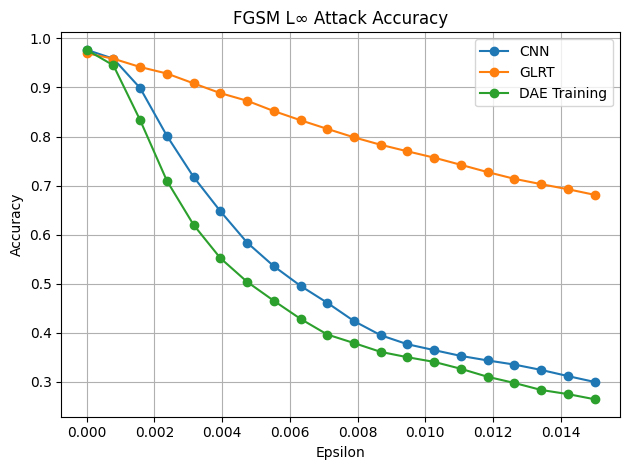

In [20]:
fgsm_inf.plot(
    x="epsilon",
    y=["cnn_accuracy", "glrt_accuracy", "dae_trained"],
    marker='o'
)

plt.title("FGSM L∞ Attack Accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(["CNN", "GLRT", "DAE Training"])
plt.tight_layout()
plt.show()

In [21]:
fgsm_inf.to_csv('../results/baseline/doa/fgsm_inf_accuracy_with_dae.csv', index=False)

In [22]:
# dae training
acc_dae_fgsm_l2, preds_dae_fgsm_l2 = evaluate_cnn_across_epsilons(
    model_dae_fgsm_l2, X_test_cov, y_test_onehot,
    epsilon_values_l2, attack_type='fgsm', norm='2'
)

[FGSM-2] Epsilon = 0.00000
Mean absolute perturbation at epsilon=0.00000: 0.000000
[FGSM-2] Epsilon = 0.00421
Mean absolute perturbation at epsilon=0.00421: 0.000140
[FGSM-2] Epsilon = 0.00842
Mean absolute perturbation at epsilon=0.00842: 0.000281
[FGSM-2] Epsilon = 0.01263
Mean absolute perturbation at epsilon=0.01263: 0.000421
[FGSM-2] Epsilon = 0.01684
Mean absolute perturbation at epsilon=0.01684: 0.000562
[FGSM-2] Epsilon = 0.02105
Mean absolute perturbation at epsilon=0.02105: 0.000702
[FGSM-2] Epsilon = 0.02526
Mean absolute perturbation at epsilon=0.02526: 0.000843
[FGSM-2] Epsilon = 0.02947
Mean absolute perturbation at epsilon=0.02947: 0.000983
[FGSM-2] Epsilon = 0.03368
Mean absolute perturbation at epsilon=0.03368: 0.001123
[FGSM-2] Epsilon = 0.03789
Mean absolute perturbation at epsilon=0.03789: 0.001264
[FGSM-2] Epsilon = 0.04211
Mean absolute perturbation at epsilon=0.04211: 0.001404
[FGSM-2] Epsilon = 0.04632
Mean absolute perturbation at epsilon=0.04632: 0.001545
[FGS

In [23]:
fgsm_l2['dae_trained'] = acc_dae_fgsm_l2

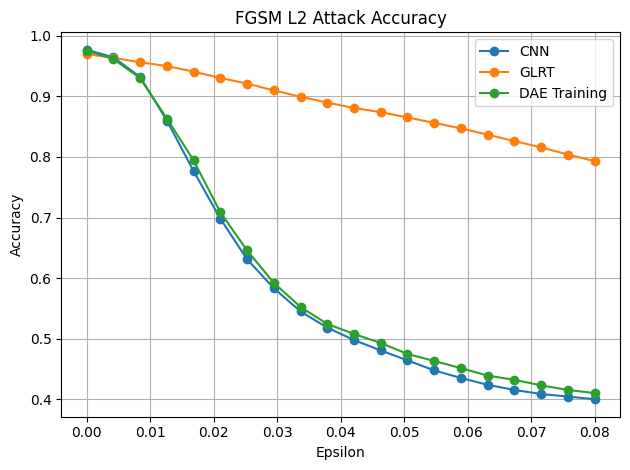

In [24]:
fgsm_l2.plot(
    x="epsilon",
    y=["cnn_accuracy", "glrt_accuracy", "dae_trained"],
    marker='o'
)

plt.title("FGSM L2 Attack Accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(["CNN", "GLRT", "DAE Training"])
plt.tight_layout()
plt.show()

In [25]:
fgsm_l2.to_csv('../results/baseline/doa/fgsm_l2_accuracy_with_dae.csv', index=False)

In [26]:
# distillation
acc_dae_pgd_inf, preds_dae_pgd_inf = evaluate_cnn_across_epsilons(
    model_dae_pgd_inf, X_test_cov, y_test_onehot,
    epsilon_values_inf, attack_type='pgd', norm='inf'
)

[PGD-inf] Epsilon = 0.00000
Mean absolute perturbation at epsilon=0.00000: 0.000000
[PGD-inf] Epsilon = 0.00079
Mean absolute perturbation at epsilon=0.00079: 0.000739
[PGD-inf] Epsilon = 0.00158
Mean absolute perturbation at epsilon=0.00158: 0.001434
[PGD-inf] Epsilon = 0.00237
Mean absolute perturbation at epsilon=0.00237: 0.002098
[PGD-inf] Epsilon = 0.00316
Mean absolute perturbation at epsilon=0.00316: 0.002732
[PGD-inf] Epsilon = 0.00395
Mean absolute perturbation at epsilon=0.00395: 0.003327
[PGD-inf] Epsilon = 0.00474
Mean absolute perturbation at epsilon=0.00474: 0.003872
[PGD-inf] Epsilon = 0.00553
Mean absolute perturbation at epsilon=0.00553: 0.004360
[PGD-inf] Epsilon = 0.00632
Mean absolute perturbation at epsilon=0.00632: 0.004808
[PGD-inf] Epsilon = 0.00711
Mean absolute perturbation at epsilon=0.00711: 0.005220
[PGD-inf] Epsilon = 0.00789
Mean absolute perturbation at epsilon=0.00789: 0.005606
[PGD-inf] Epsilon = 0.00868
Mean absolute perturbation at epsilon=0.00868: 0

In [27]:
pgd_inf['dae_trained'] = acc_dae_pgd_inf

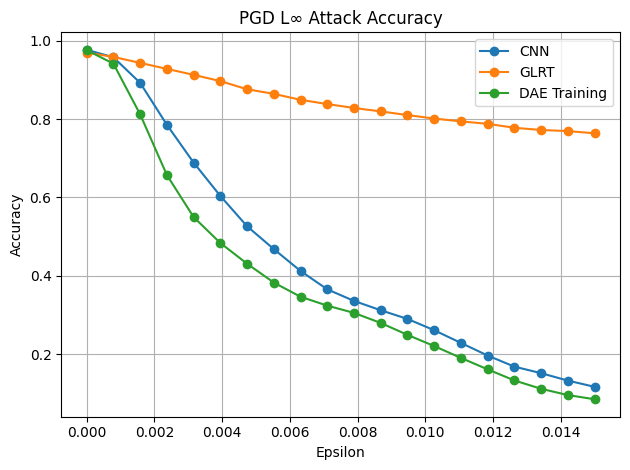

In [28]:
pgd_inf.plot(
    x="epsilon",
    y=["cnn_accuracy", "glrt_accuracy", "dae_trained"],
    marker='o'
)

plt.title("PGD L∞ Attack Accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(["CNN", "GLRT", "DAE Training"])
plt.tight_layout()
plt.show()
# white box attack which means we're attacking the dae + cnn together, overparameterized model compared to
# cnn. overparameterized model amplifies the attack, lower potency.

In [29]:
pgd_inf.to_csv('../results/baseline/doa/pgd_inf_accuracy_with_dae.csv', index=False)

In [30]:
# distillation
acc_dae_pgd_l2, preds_dae_pgd_l2 = evaluate_cnn_across_epsilons(
    model_dae_pgd_l2, X_test_cov, y_test_onehot,
    epsilon_values_l2, attack_type='pgd', norm='2'
)

[PGD-2] Epsilon = 0.00000
Mean absolute perturbation at epsilon=0.00000: 0.000000
[PGD-2] Epsilon = 0.00421
Mean absolute perturbation at epsilon=0.00421: 0.000148
[PGD-2] Epsilon = 0.00842
Mean absolute perturbation at epsilon=0.00842: 0.000296
[PGD-2] Epsilon = 0.01263
Mean absolute perturbation at epsilon=0.01263: 0.000444
[PGD-2] Epsilon = 0.01684
Mean absolute perturbation at epsilon=0.01684: 0.000592
[PGD-2] Epsilon = 0.02105
Mean absolute perturbation at epsilon=0.02105: 0.000739
[PGD-2] Epsilon = 0.02526
Mean absolute perturbation at epsilon=0.02526: 0.000886
[PGD-2] Epsilon = 0.02947
Mean absolute perturbation at epsilon=0.02947: 0.001032
[PGD-2] Epsilon = 0.03368
Mean absolute perturbation at epsilon=0.03368: 0.001177
[PGD-2] Epsilon = 0.03789
Mean absolute perturbation at epsilon=0.03789: 0.001319
[PGD-2] Epsilon = 0.04211
Mean absolute perturbation at epsilon=0.04211: 0.001456
[PGD-2] Epsilon = 0.04632
Mean absolute perturbation at epsilon=0.04632: 0.001587
[PGD-2] Epsilon 

In [31]:
pgd_l2['dae_trained'] = acc_dae_pgd_l2

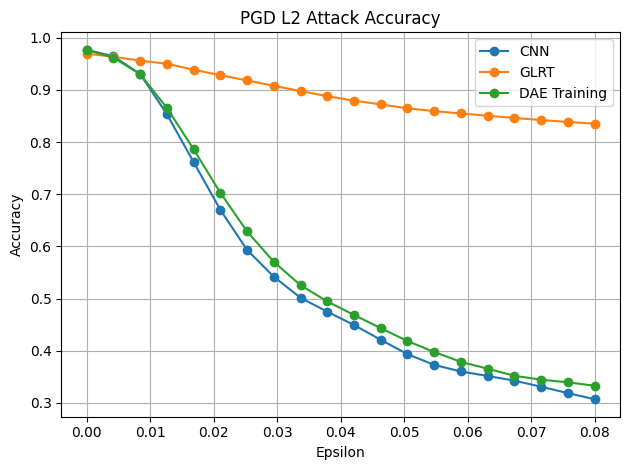

In [32]:
pgd_l2.plot(
    x="epsilon",
    y=["cnn_accuracy", "glrt_accuracy", "dae_trained"],
    marker='o'
)

plt.title("PGD L2 Attack Accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(["CNN", "GLRT", "DAE Training"])
plt.tight_layout()
plt.show()

In [33]:
pgd_l2.to_csv('../results/baseline/doa/pgd_l2_accuracy_with_dae.csv', index=False)